```{currentmodule} tskit
```

In [1]:
import msprime
import tskit
import numpy as np

def basics():
    ts = msprime.sim_ancestry(3, random_seed=10, sequence_length=1000, recombination_rate=1e-4)
    ts = msprime.sim_mutations(ts, rate=1e-4, random_seed=150)
    tables = ts.dump_tables()
    # populations already has a schema
    populations_md = [p.metadata for p in ts.populations()]
    populations_md[0]["name"] = "GBR"
    populations_md[0]["description"] = "British from England and Scotland"
    
    tables.populations.packset_metadata(
        [tables.populations.metadata_schema.validate_and_encode_row(r) for r in populations_md]
    )
    individuals_md = [{"name": "Ada"}, {"name": "Bob"}, {"name": "Cat"}]
    tables.individuals.metadata_schema = tskit.MetadataSchema({'codec': 'json'})
    tables.individuals.packset_metadata(
        [tables.individuals.metadata_schema.validate_and_encode_row(r) for r in individuals_md]
    )
    tables.mutations.time = np.full_like(tables.mutations.time, tskit.UNKNOWN_TIME)
    tables.tree_sequence().dump("data/basics.trees")
    


def create_notebook_data():
    basics()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_basics)=

# Tree sequence basics

If you have read "{ref}`sec_what_is`" we hope to have piqued your interest in tree
sequences. This tutorial serves as an introdution to the terminology and some of the
concepts behind {program}`tskit`, the tree sequence toolkit.

## Terminology

A tree sequence is a data structure which describes a set of
evolutionary trees, together with some associated data that specifies, for example,
the location of mutations in the tree sequence. Here's how to {func}`~tskit.load` one
from a `.trees` file using the {ref}`tskit:sec_python_api`:

In [2]:
import tskit
# We will often store the python tree sequence object in a variable named "ts"
ts = tskit.load("data/basics.trees")

### Genomes

A tree sequence covers a contiguous section of a single chromosome[^multiple_chr_foot].
For clarity of explanation, we use the word "genome" to refer to the section spanned by
the whole tree sequence (if you find it easier, imagine our examples describe an
organism with a single, short chromosome). In the tree sequence we have just loaded,
the genome is of length 1000, conventionally interpreted as the number of base
pairs. This is accessible using the {attr}`~TreeSequence.sequence_length` attribute.

In [3]:
ts.sequence_length  # a floating point number: positions are not constrained to be integers

1000.0

It can be helpful to visualize the tree sequence as a set of local trees along the genome:

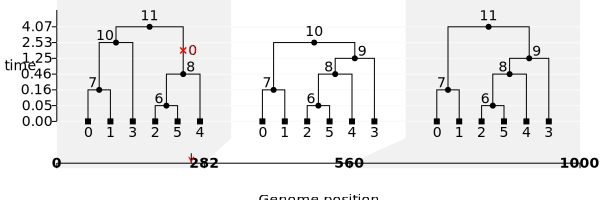

In [4]:
from IPython.display import SVG
SVG(ts.draw_svg(y_axis=True, y_gridlines=True, time_scale="rank"))

Each tree records the lines of descent along which a piece of DNA has been
inherited (ignore for the moment the red symbols, which represent a mutation).
For example, the first tree tells us that DNA from ancestral genome 7 duplicated
to produce two lineages, which ended up in sample genome 0 and sample genome 1 in the
current population (since this pattern is seen in all trees, this must have happened
for all the DNA along the entire 1000 base pair genome).

[^multiple_chr_foot]: {ref}`Workarounds<msprime:sec_ancestry_multiple_chromosomes>` exist
which allow a genome composed of multiple chromosomes to be represented as a tree
sequence, but these are not covered here.


### Nodes

Trees in a tree sequence are represented in a slightly unusual way.
In the majority of libraries dealing with trees, each node is represented
as an object in memory and the relationship between nodes as pointers between these
objects. In tree sequences, however, all nodes, both internal and terminal,
are represented by an integer ID, unique over the entire tree sequence, and which exists
at a specific point in time. The tips (leaves) of the tree, are usually marked as
*sample nodes*, represented by square symbols in the visualization. In most cases
sample nodes will be on the tips of a tree: they represent genomes with a fully known
genetic sequence. Internal nodes (circles) represent ancestors in which a single DNA
sequence was duplicated (in forwards-time terminology) or in which multiple sequences
coalesced (in backwards-time terminology). There are 6 sample nodes, labelled $0..5$,
and also 6 non-sample nodes, labelled $6..11$, in the tree sequence above:

In [5]:
print("There are", ts.num_nodes, "nodes, of which", ts.num_samples, "are sample nodes")

There are 12 nodes, of which 6 are sample nodes


### Edges

In an evolutionary tree, the connections between nodes are conventionally referred to as
"branches". In a tree sequence, we instead refer to directional connections between nodes
as _edges_, emphasizing that they usually persist across multiple trees. Each edge is
associated with a parent node ID and a child node ID. The time of the parent node must be
strictly greater than the time of the child node, and the difference in these times is
sometimes referred to as the "length" of the edge. Since trees in a tree sequence are
usually taken to represent marginal trees along a genome, as well as the time dimension
each edge also has a genomic _span_, defined by the edge's *left* and a *right* position
along the genome. There are 15 edges in the tree sequence above. Here's an example of
one of them:

In [6]:
print("There are", ts.num_edges, "edges, one of which is:\n ", ts.edge(10))

There are 15 edges, one of which is:
  Edge(left=282.0, right=560.0, parent=10, child=9, metadata=b'', id=10)


:::{note}
The *number of edges* largely determines the entire size of a tree sequence file. Edges
essentially encode ancestral information, and the number in a tree sequence can
be used as a rough measure of many things such as the compressibility of a simulation,
the speed with which analyses are likely to run, or even the effectiveness of ancestral
inference. To give some sense of scale, a basic inferred tree sequence of human
chromosome 20 in the UK Biobank dataset of a million genomes consists of 62 million edges
which define 16 thousand trees; the uncompressed tree sequence takes 2.1 gigabytes of
disk space, and it takes of the order of a few seconds to iterate over all the trees.
:::


### Trees and tree sequences

The combination of nodes and edges results in a tree sequence. Note that the
sample nodes ($0..5$) are present in all trees since we have their full genomes.
Additionally, internal nodes are commonly present in several, although not all,
trees in the tree sequence.

In tree sequence terminology, we don't explictly keep track of where nodes
start and end. Only edges (not nodes) possess a genomic span. So for example, this tree
sequence is defined using edges like $(0\rightarrow7)$ which spans the entire genome,
edges like $(10\rightarrow3)$ which only span the leftmost section of the genome, and
edges like $(11\rightarrow9)$ which span the rightmost part of the genome. Every time an
edge changes it creates a new tree; the location of the change is known as a _breakpoint_:

In [7]:
print("There are", ts.num_trees, "trees, with breakpoints", ts.breakpoints(as_array=True))

There are 3 trees, with breakpoints [   0.  282.  560. 1000.]


:::{note}
The tree sequence we have used here involves a tree with strictly bifurcating splits, but
this does not need to be the case for tree sequences in general. In particular, where
tree sequences have been created by the multiple-merger coalecent process, or in tree
sequences that have been inferred from real data, it is possible to have a parent node
with 3 or more children in a particular tree. Such multifucations are known as
*polytomies*.
:::

### Individuals and populations

Sometimes we know that one or more nodes belong to a particular _individual_. For example,
most organisms are diploid, so if we sequence the DNA from an individual we are likely to
obtain two copies of each autosomal chromosome. The tree with six sample nodes above
could therefore represent the result of sampling three diploid individuals from a larger
population. The tree sequence can keep track of the individuals in which nodes reside,
and store specific information about them (such as the individuals' spatial location)
as well as arbitrary {ref}`metadata <sec_metadata>` (such as a name). In this particular
tree sequence the sample nodes are indeed associated with three named diploid
individuals: ``Ada``, ``Bob`` and ``Cat``.

In [8]:
print(f"There are {ts.num_individuals} individuals defined in the tree sequence:")
for individual in ts.individuals():
    print("*", f"Individual {individual.id}: metadata={individual.metadata}")

There are 3 individuals defined in the tree sequence:
* Individual 0: metadata={'name': 'Ada'}
* Individual 1: metadata={'name': 'Bob'}
* Individual 2: metadata={'name': 'Cat'}


Adding these individual names to the sample node labels show that indeed, each of the
three individuals has 2 sample nodes (note that these 2 nodes do not always cluster
together in the trees, as the original simulation was of a randomly mating population)

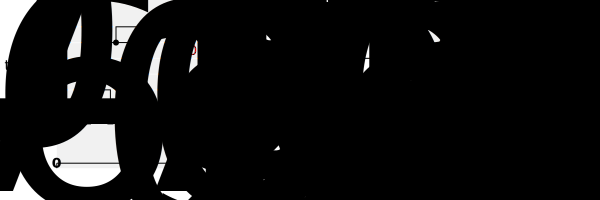

In [9]:
node_labels = {node.id: str(node.id) for node in ts.nodes()}
for n in ts.samples():
    node_labels[n] = f"{n} ({ts.individual(ts.node(n).individual).metadata['name']})"
styles = (
    ".node > .lab {font-size: 70%}"
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
)
SVG(ts.draw_svg(
    node_labels=node_labels, style=styles, y_axis=True, y_gridlines=True, time_scale="rank"))

In the same way that nodes can be associated with a specific individual, nodes can also
be associated with a larger _population_. In this example, there is only one population
(to which all the nodes belong):

In [10]:
print(f"{ts.num_populations} population(s) defined:")
for population in ts.populations():
    print("*", population)

1 population(s) defined:
* Population(id=0, metadata={'description': 'British from England and Scotland', 'name': 'GBR'})


### Mutations and sites

In {program}`tskit`, _mutations_ occur at specific, defined _sites_. A mutation is
positioned above a particular node (specified by the node ID), occurs at a particular
site (specified by a site ID), and involves a change of allelic state to a defined
{attr}`~Mutation.derived_state`. A mutation therefore can be specified something like
this:

In [11]:
print(f"{ts.num_mutations} mutation(s) in the tree sequence:")
for mutation in ts.mutations():
    print("*", mutation)

1 mutation(s) in the tree sequence:
* Mutation(id=0, site=0, node=8, derived_state='G', parent=-1, metadata=b'', time=nan)


The mutation can have a {attr}`~Mutation.time` or if, as in this case, the times of
mutations in the tree sequence are unknown, all mutations can have the special NaN value
``tskit.UNKNOWN_TIME``. Notice that the genomic position of the mutation is not included.
Instead, that is a property of the _site_ to which the mutation refers, in this case,
site ID 0 (which happens to be at position 257):

In [12]:
print(ts.site(0))  # For convenience, the Python API returns the mutations at this site too

Site(id=0, position=257.0, ancestral_state='T', mutations=[Mutation(id=0, site=0, node=8, derived_state='G', parent=-1, metadata=b'', time=nan)], metadata=b'')


In the plot above, since the the only mutation is above node 8 and has a
{attr}`~Mutation.derived_state` of "G", we know that the samples descending from node
8 in the first tree (sample genomes 2, 4, and 5) have a "G" at {attr}`~Site.position` 257,
while the others have the {attr}`~Site.ancestral_state` of "T". This means that Ada is
homozygous for "T", Bob is heterozygous "T|G", and Cat is homozygous for "G".
In other words the ancestral state and the details of any mutations at that site,
when coupled with the tree topology at the site {attr}`~Site.position` is sufficient to
define the allelic state possessed by each sample.

Note that even though the genome is 1000 base pairs long, the tree sequence only contains
a single site, because we usually only bother defining *variable* sites in a tree
sequence (e.g. positions seen in studies to have samples possessing different alleles at
that genomic location). It is perfectly possible to have a site with no mutations
(or silent mutations) --- i.e. a "monomorphic" site --- but such sites are not normally
used in further analysis.

### Provenance

:::{todo}
What is provenance
:::


## Concepts

There are some basic population genetic concepts which can be helpful with thinking about
tree sequences. For reference, here is the tree sequence topology that we have been using:

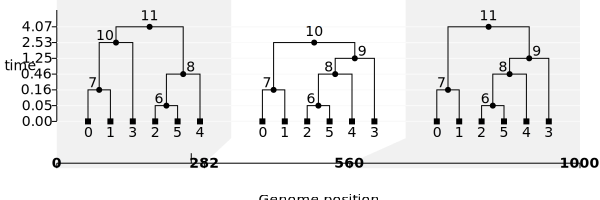

In [13]:
from IPython.display import SVG
SVG(ts.draw_svg(y_axis=True, y_gridlines=True, time_scale="rank", style=".mut {display: none}"))

### Tree changes, ancestral recombinations, and SPRs

Note that adjacent trees in this tree sequence differ by a single "tree edit" or SPR
(subtree-prune-and-regraft) operation: the subtree defined by node 8 in the first
tree has been pruned and regrafted onto the branch from 10 to 3, to create the
second tree.

The second and third trees have the same topology, but differ because their
ultimate coalesence happened in a different ancestor (this is easy to see in a simulation,
but hard to detect in real data). The SPR that created the third tree must involve pruning
either the subtree below node 7 or the subtree below node 9 and grafted it higher up on
the same lineage. In this case it turns out to be impossible to tell just from the tree
sequence which of those two SPRs actually happened in the simulation.

In general, each detectable recombination occurring in ancestral history results in a
single SPR in the tree sequence. If recombination breakpoints occurs at unique
positions (an "infinite sites" model of breakpoints), then the number of trees in a tree
sequence equals the number of ancestral recombination events plus one. If recombinations
can occur at the same physical position (e.g. if the genome is treated as a set of discrete
integer positions, as in the simulation that created this tree sequence) then moving from 
ne tree to the next in a tree sequence might require multiple SPRs, because there are
multiple, overlaid ancestral recombination events.

### Tree sequences and ARGs

Much of the literature on ancestral inference concentrates on the Ancestral Recombination
Graph, or ARG, in which details of the position and potentially the timing of
recombination events are explictly stored. Although a tree sequence can represent an ARG,
by incorporating nodes that represent recombination events, this is not normally done for
two reasons:

1. Many recombination events are undetectable from sequence data, and even if they are
   detectable, they can be logically impossible to place in the genealogy (as in the
   second SPR example above).
2. The number of recombination events in the genealogy can grow to dominate the total
   number of nodes in the total tree sequence, without actually contributing to the
   realised sequences in the samples. In other words, recombination nodes are redundant
   to the storing of genome data.

In other words, compared to an ARG, a standard tree sequence simply stores the trees
created by recombination events, rather than attempting to record the recombination
events themselves. Many (but as we have seen, not all) details of the actual
recombination events can be inferred from the changes in edges along a tree sequence.
In other words

> "an ARG encodes the events that occurred in the history of a sample,
> whereas a tree sequence encodes the outcome of those events"
> ([Kelleher _et al._, 2019](https://doi.org/10.1534/genetics.120.303253))

:::{todo}
Link to the ARG tutorial: https://github.com/tskit-dev/tutorials/issues/43
:::


### Tables

:::{todo}
The underlying data in a tree sequence is stored of as a set of tables. The API
for dealing with a tree sequence as a collection of tables is sometimes useful,
especially if you want to edit an existing tree sequence: more details in the
{ref}`sec_data_structures` tutorial.
:::